In [1]:
import copy
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import cKDTree
import xarray as xr
import yaml

### Files paths

In [2]:
yaml_file = './config/pre_processing.yaml'
params = yaml.safe_load(open(yaml_file))

# The global mesh
INPUT_GRID = params['input_grid_nc']

# The SSH and seg masks info
INPUT_PATH_SSH_SEG_MASK = params['input_path_ssh_seg_masks']

# The other FESOM variables - UNOD and VNOD
INPUT_PATH_OTHER_VARS = params['input_path_other_vars']

# Output subset mesh details
OUTPUT_PATH_MESH = params['output_subset_pre_proc']
OUTPUT_MESH = params['output_mesh']

# The /raw destination folder for the pre-processed data
OUTPUT_SUBSET_PRE_PROCESSED = params['output_subset_pre_proc_raw']

### Reduce the mesh to a subset

In [3]:
files = os.listdir(OUTPUT_PATH_MESH)

if OUTPUT_MESH in files:
    print(f"\nThe file {OUTPUT_MESH} is already on the filesystem.")
    data_mesh = xr.open_dataset(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')
    print(data_mesh)
else:
    data_mesh = xr.open_dataset(INPUT_GRID, engine='netcdf4')

    # Deletion of useless fields
    vars_keys = data_mesh.data_vars
    for key in vars_keys:
        if key != 'lat' and key != 'lon' and key != 'edges' and key != 'nodes':
            data_mesh = data_mesh.drop_vars(key)

    data_mesh = data_mesh.drop_vars('nz')
    data_mesh = data_mesh.drop_vars('nz1')

    # RoI definition
    model_lon = data_mesh.lon.values
    model_lat = data_mesh.lat.values
    left = params['input_left']
    right = params['input_right']
    bottom = params['input_bottom']
    top = params['input_top']
    region_mask = (model_lon > left) & (model_lon < right) & (model_lat < top) & (model_lat > bottom)

    # Nodes extraction
    nodes_subset = []
    for i in range(len(region_mask)):
        if region_mask[i]:
            nodes_subset.append(i)

    nodes_subset = np.array(nodes_subset, dtype="int32")
    data_mesh['nodes'] =(('nodes_subset'), nodes_subset)

    # Prepare the translation from global to local nodes indexing
    tmp_index_dict = {}
    tmp_nodes = data_mesh.nodes.values

    for i in range(data_mesh.dims['nodes_subset']):
        tmp_index_dict[tmp_nodes[i]] = i

    # RoI: edges extraction
    edge_0 = data_mesh.edges[0].values
    edge_1 = data_mesh.edges[1].values
    edge_0 -= 1
    edge_1 -= 1

    edges_subset = []
    for i in range(len(edge_0)):
        if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
            edges_subset.append([edge_0[i], edge_1[i]])

    edges_subset_loc = copy.deepcopy(edges_subset)

    # Global to local translation
    for i in range(len(edges_subset)):
        edges_subset_loc[i][0] = tmp_index_dict[edges_subset[i][0]]
        edges_subset_loc[i][1] = tmp_index_dict[edges_subset[i][1]]

    edges_subset = np.array(edges_subset, dtype="int32")
    edges_subset_loc = np.array(edges_subset_loc, dtype="int32")
    data_mesh = data_mesh.drop_vars('edges')
    data_mesh['edges_global'] = (('n2', 'edges_subset'), edges_subset.T)
    data_mesh['edges_local'] = (('n2', 'edges_subset'), edges_subset_loc.T)

    data_mesh.to_netcdf(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')

data_mesh


The file subset_mesh.nc is already on the filesystem.
<xarray.Dataset>
Dimensions:       (nod2: 8852366, nodes_subset: 757747, n2: 2,
                   edges_subset: 2268763)
Dimensions without coordinates: nod2, nodes_subset, n2, edges_subset
Data variables:
    lon           (nod2) float64 ...
    lat           (nod2) float64 ...
    nodes         (nodes_subset) int32 ...
    edges_global  (n2, edges_subset) int32 ...
    edges_local   (n2, edges_subset) int32 ...


<xarray.Dataset>
Dimensions:       (nod2: 8852366, nodes_subset: 757747, n2: 2,
                   edges_subset: 2268763)
Dimensions without coordinates: nod2, nodes_subset, n2, edges_subset
Data variables:
    lon           (nod2) float64 ...
    lat           (nod2) float64 ...
    nodes         (nodes_subset) int32 ...
    edges_global  (n2, edges_subset) int32 ...
    edges_local   (n2, edges_subset) int32 ...

### Interpolation of SSH and segmentation mask to the unstructured subset grid

#### First, some helper functions from https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/FESOM/STARTHERE_FESOM.ipynb

In [4]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [5]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    
    xs, ys, zs = lon_lat_to_cartesian(lons.flatten(), lats.flatten())
    xt, yt, zt = lon_lat_to_cartesian(model_lon, model_lat)

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

### Vnod and Unod variables preparation

In [6]:
filename_unod = 'unod.fesom.'
files_unod = os.path.join(INPUT_PATH_OTHER_VARS, f"{filename_unod}*.nc")
files_unod = glob.glob(files_unod)
files_unod.sort()
files_unod = files_unod[:-1]    # Remove incomplete year 2022
for file in files_unod:
    print(file)

filename_vnod = 'vnod.fesom.'
files_vnod = os.path.join(INPUT_PATH_OTHER_VARS, f"{filename_vnod}*.nc")
files_vnod = glob.glob(files_vnod)
files_vnod.sort()
files_vnod = files_vnod[:-1]    # Remove incomplete year 2022
for file in files_vnod:
    print(file)

# Load all unod and vnod files and concatenate per time
data_unod = xr.open_mfdataset(files_unod, combine='nested', concat_dim='time')
data_vnod = xr.open_mfdataset(files_vnod, combine='nested', concat_dim='time')

# Keep just the level that's closest to the surface
data_unod = data_unod.isel(nz1=0)
data_vnod = data_vnod.isel(nz1=0)

# Remove all useless attributes
data_unod.attrs.clear()
data_vnod.attrs.clear()

# Filter for subset mesh
data_unod = data_unod.sel(nod2=data_mesh.nodes)
data_vnod = data_vnod.sel(nod2=data_mesh.nodes)

/scratch/a/a270088/FORCA12_opt7/unod.fesom.2020.nc
/scratch/a/a270088/FORCA12_opt7/unod.fesom.2021.nc
/scratch/a/a270088/FORCA12_opt7/vnod.fesom.2020.nc
/scratch/a/a270088/FORCA12_opt7/vnod.fesom.2021.nc


In [7]:
data_unod

<xarray.Dataset>
Dimensions:  (time: 731, nodes_subset: 757747)
Coordinates:
    nz1      float64 2.5
  * time     (time) datetime64[ns] 2020-01-01T23:54:00 ... 2021-12-31T23:54:00
Dimensions without coordinates: nodes_subset
Data variables:
    unod     (time, nodes_subset) float32 dask.array<chunksize=(1, 1872), meta=np.ndarray>

In [8]:
data_vnod

<xarray.Dataset>
Dimensions:  (time: 731, nodes_subset: 757747)
Coordinates:
    nz1      float64 2.5
  * time     (time) datetime64[ns] 2020-01-01T23:54:00 ... 2021-12-31T23:54:00
Dimensions without coordinates: nodes_subset
Data variables:
    vnod     (time, nodes_subset) float32 dask.array<chunksize=(1, 1872), meta=np.ndarray>

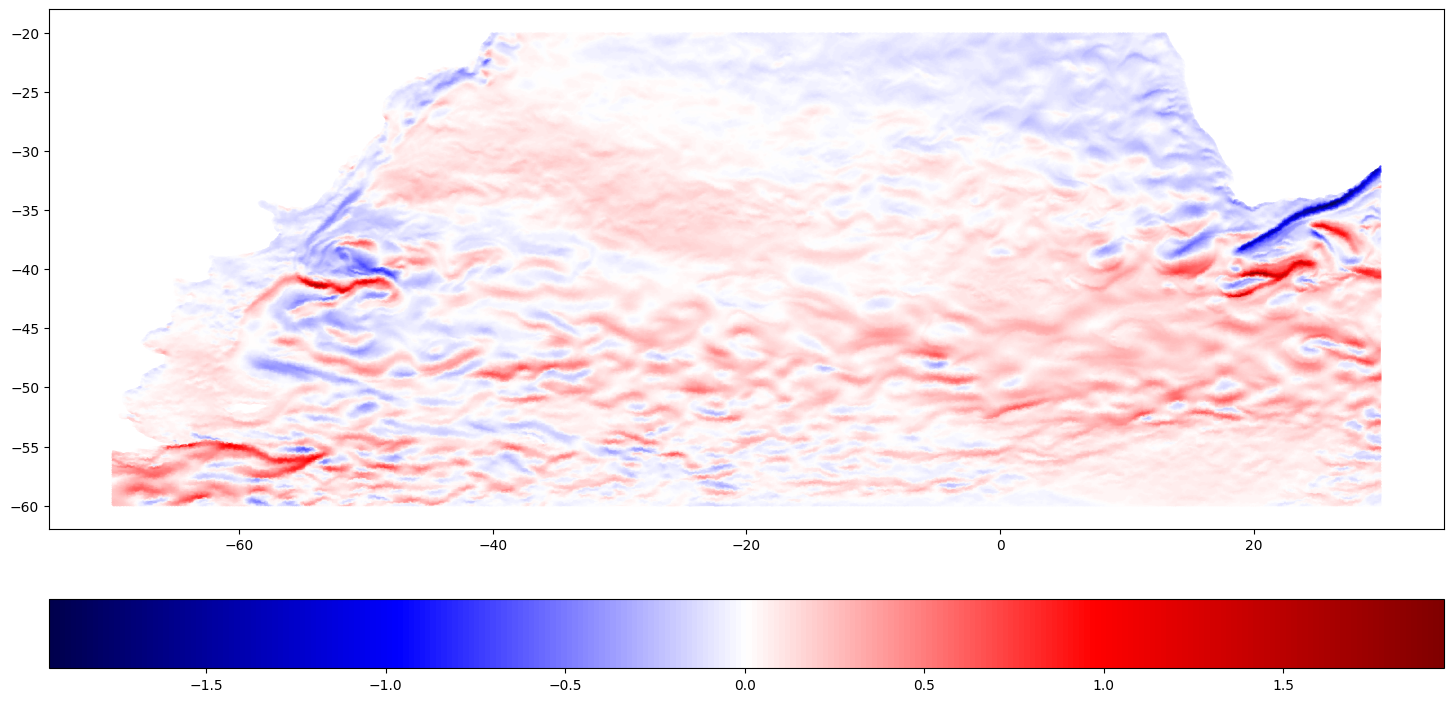

In [9]:
model_lon = data_mesh.lon.values
model_lat = data_mesh.lat.values

plt.figure(figsize=(18, 9))

plt.scatter(model_lon[data_mesh.nodes], model_lat[data_mesh.nodes], c=data_unod.isel(time=0).unod, s=0.1, cmap=cm.seismic)
plt.colorbar(orientation='horizontal', pad=0.1)

plt.show()

### The entire interpolation process

In [10]:
# Avoid re-creating already existing files
files = os.listdir(OUTPUT_SUBSET_PRE_PROCESSED)

# SSH and segmentation masks (the SSH information is stored together with the segmentation masks)
data_files = []
for file in os.listdir(INPUT_PATH_SSH_SEG_MASK):
    data_files.append(file)

# Target coordinates(the unstructured FESOM mesh)
model_lon = data_mesh.lon[data_mesh.nodes].values
model_lat = data_mesh.lat[data_mesh.nodes].values

# Source coordinates(since lat and lon should always be the same, we just take them from a file and calculate the indexes once)
data_month = xr.open_dataset(INPUT_PATH_SSH_SEG_MASK + str(data_files[0]))
data_lon, data_lat = np.meshgrid(data_month['LONGITUDE'], data_month['LATITUDE'])
data_lon = data_lon.T
data_lat = data_lat.T

# Perform a K-Nearest Neighbors between matrix and mesh points
distances, inds = create_indexes_and_distances(model_lon, model_lat, data_lon, data_lat, k=1, workers=-1)

for file in data_files:
    data_month = xr.open_dataset(INPUT_PATH_SSH_SEG_MASK + str(file))
    
    year = file.split('_')[3]
    month = file.split('_')[4].split('.')[0]
    day = None
    
    print(f'Preprocessing year {year}, month {month}')

    for d in range(data_month.dims['TIME']):
        data_month.dims
        day = d+1
        
        file_name = 'data_' + str(year) + '_' + str(month) + '_' + str(day) + '.nc'
        if file_name not in files:
        
            # SSH values
            data_ssh_values = data_month.ssh[d].values

            # To avoid the e+36 values of SSH that NetCDF put there to create the land
            data_ssh_values[data_ssh_values > 10] = 0

            # Segmentation mask
            data_seg_mask_values = data_month.seg_mask[d].values

            # TODO Temporary fix for single "3" value in the seg_mask variable
            for r in range(data_month.dims['LONGITUDE']):
                for c in range(data_month.dims['LATITUDE']):
                    if data_seg_mask_values[r][c] < 0 or data_seg_mask_values[r][c] > 2:
                        neighbors = data_seg_mask_values[r][c-1]+data_seg_mask_values[r-1][c-1]+data_seg_mask_values[r-1][c]+data_seg_mask_values[r-1][c+1]+data_seg_mask_values[r][c+1]+data_seg_mask_values[r+1][c+1]+data_seg_mask_values[r+1][c]+data_seg_mask_values[r+1][c-1]
                        neighbors /= 8
                        print(file, d, r, c, data_seg_mask_values[r][c])
                        print(f'Neighborhood average(assuming the 8 neighbors exist): {neighbors}, assigning a {round(neighbors)}')
                        data_seg_mask_values[r][c] = round(neighbors)

            flat_ssh = data_ssh_values.flatten()
            flat_seg_mask = data_seg_mask_values.flatten()

            ssh = flat_ssh[inds]
            seg_mask = flat_seg_mask[inds]

            # Area of influence to take care of KNN indexes crossing land
            radius_of_influence = 7000

            ssh[distances >= radius_of_influence] = 0#np.nan
            ssh = np.ma.masked_invalid(ssh)

            seg_mask[distances >= radius_of_influence] = 0
            seg_mask = np.ma.masked_invalid(seg_mask)

            ssh = np.array(ssh, dtype="float64")
            seg_mask = np.array(seg_mask, dtype="float64")
            
            # Unod and Vnod time
            time = str(year) + '-' + str(month).zfill(2) + '-' + str(day).zfill(2)
            
            # Get the raw values of unod and vnod for this time - TODO this is really slowing the process down
            unod = data_unod.sel(time=time).squeeze().unod.values
            vnod = data_vnod.sel(time=time).squeeze().vnod.values
            
            data_output = xr.Dataset(
                data_vars=dict(
                    ssh=('nodes_subset', ssh),
                    seg_mask=('nodes_subset', seg_mask),
                    unod=('nodes_subset', unod),
                    vnod=('nodes_subset', vnod)
                )
            )
            
            #print(data_output)
            #import sys
            #sys.exit()

            # Save the result in a separate file for each timestamp
            data_output.to_netcdf(OUTPUT_SUBSET_PRE_PROCESSED + file_name, engine='netcdf4')

Preprocessing year 2020, month 5
Preprocessing year 2021, month 10
Preprocessing year 2021, month 7
Preprocessing year 2021, month 1
Preprocessing year 2021, month 12
Preprocessing year 2021, month 9
Preprocessing year 2021, month 3
Preprocessing year 2020, month 11
Preprocessing year 2021, month 2
Preprocessing year 2020, month 10
Preprocessing year 2021, month 8
Preprocessing year 2020, month 6
Preprocessing year 2021, month 5
Preprocessing year 2020, month 7
Preprocessing year 2020, month 12
Preprocessing year 2021, month 6
Preprocessing year 2020, month 3
Preprocessing year 2020, month 4
Preprocessing year 2020, month 1
seg_mask_gridded_2020_1.nc 11 166 59 3
Neighborhood average(assuming the 8 neighbors exist): 1.5, assigning a 2
seg_mask_gridded_2020_1.nc 13 166 59 3
Neighborhood average(assuming the 8 neighbors exist): 1.5, assigning a 2
seg_mask_gridded_2020_1.nc 13 170 59 3
Neighborhood average(assuming the 8 neighbors exist): 1.5, assigning a 2
seg_mask_gridded_2020_1.nc 14 16

In [11]:
# Useful pieces of code 
'''
if len(ssh) == 0:
    ssh = this_ssh
else:
    ssh = np.vstack((ssh, this_ssh))

if len(seg_mask) == 0:
    seg_mask = this_seg_mask
else:
    seg_mask = np.vstack((seg_mask, this_seg_mask))

data_mesh['ssh'] = (['graph_n', 'nodes_subset'], ssh)
data_mesh['seg_mask'] = (['graph_n', 'nodes_subset'], seg_mask)
'''

"\nif len(ssh) == 0:\n    ssh = this_ssh\nelse:\n    ssh = np.vstack((ssh, this_ssh))\n\nif len(seg_mask) == 0:\n    seg_mask = this_seg_mask\nelse:\n    seg_mask = np.vstack((seg_mask, this_seg_mask))\n\ndata_mesh['ssh'] = (['graph_n', 'nodes_subset'], ssh)\ndata_mesh['seg_mask'] = (['graph_n', 'nodes_subset'], seg_mask)\n"

In [12]:
data_output

<xarray.Dataset>
Dimensions:   (nodes_subset: 757747)
Dimensions without coordinates: nodes_subset
Data variables:
    ssh       (nodes_subset) float64 0.3855 0.3872 0.3777 ... -0.00491 -0.004677
    seg_mask  (nodes_subset) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unod      (nodes_subset) float32 0.1851 0.1735 0.1224 ... 0.1389 0.1391
    vnod      (nodes_subset) float32 0.2217 0.2113 0.1543 ... 0.009305 0.00663

### Group of plots to understand the passage of SSH and seg_mask from structured to unstructured

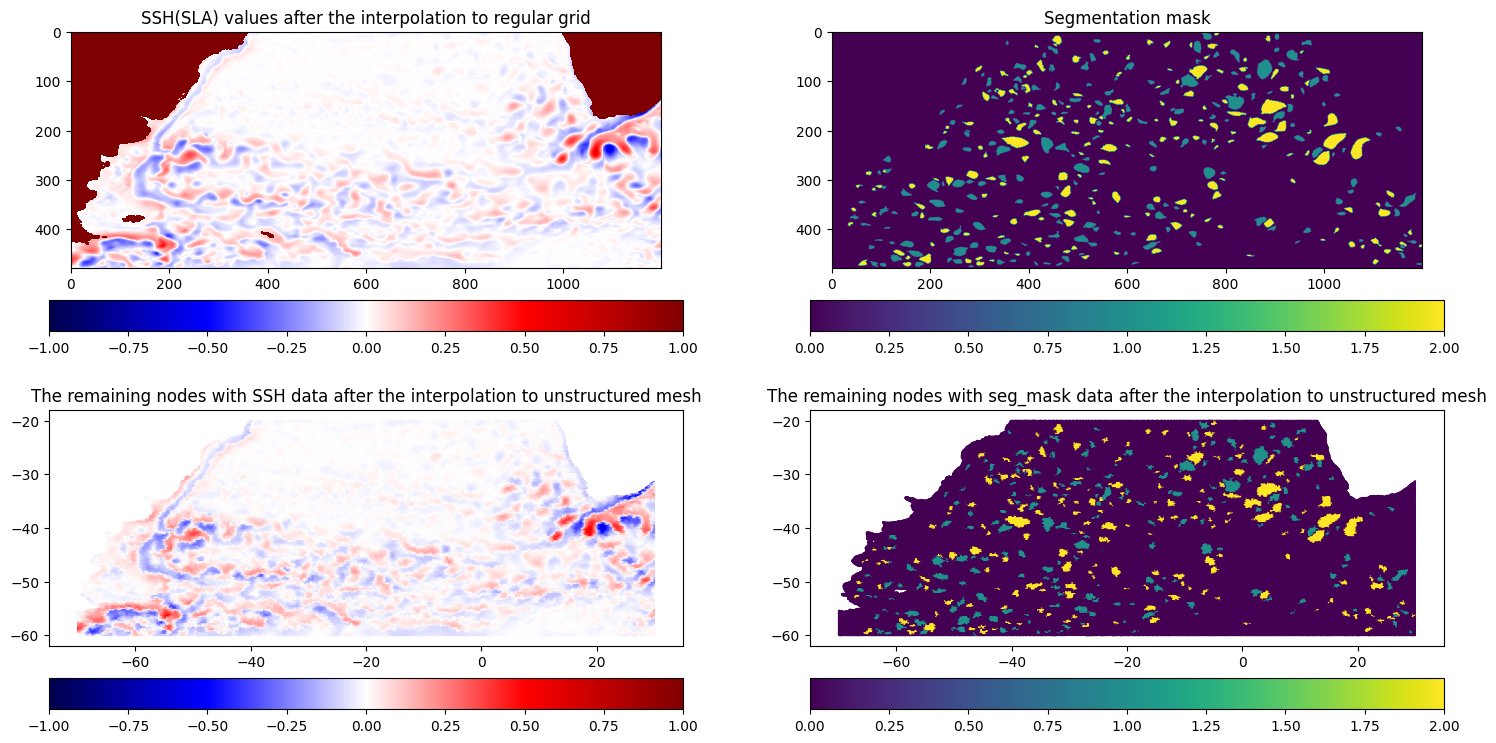

In [13]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values
uns_ssh = data_output.ssh.values
str_ssh = data_month.ssh.values[-1]
uns_seg_mask = data_output.seg_mask.values
str_seg_mask = data_month.seg_mask.values[-1]

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

im = axes[0][0].imshow(np.flipud(str_ssh.T), cmap=cm.seismic, vmin=-1, vmax=1)
axes[0][0].set_title("SSH(SLA) values after the interpolation to regular grid")
cb = plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[0][0])

im2 = axes[0][1].imshow(np.flipud(str_seg_mask.T), cmap=cm.viridis, vmin=0, vmax=2)
axes[0][1].set_title("Segmentation mask")
cb = plt.colorbar(im2, orientation='horizontal', pad=0.1, ax=axes[0][1])

im3 = axes[1][0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=0.1, cmap=cm.seismic, vmin=-1, vmax=1)
axes[1][0].set_title(f"The remaining nodes with SSH data after the interpolation to unstructured mesh")
plt.colorbar(im3, orientation='horizontal', pad=0.1, ax=axes[1][0])

im4 = axes[1][1].scatter(model_lon_roi, model_lat_roi, c=uns_seg_mask, s=0.1, cmap=cm.viridis, vmin=0, vmax=2)
axes[1][1].set_title(f"The remaining nodes with seg_mask data after the interpolation to unstructured mesh")
plt.colorbar(im4, orientation='horizontal', pad=0.1, ax=axes[1][1])

### The added variables

'\nim3 = axes[1][0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=0.1, cmap=cm.seismic, vmin=-1, vmax=1)\naxes[1][0].set_title(f"The remaining nodes with SSH data after the interpolation to unstructured mesh")\nplt.colorbar(im3, orientation=\'horizontal\', pad=0.1, ax=axes[1][0])\n\nim4 = axes[1][1].scatter(model_lon_roi, model_lat_roi, c=uns_seg_mask, s=0.1, cmap=cm.viridis, vmin=0, vmax=2)\naxes[1][1].set_title(f"The remaining nodes with seg_mask data after the interpolation to unstructured mesh")\nplt.colorbar(im4, orientation=\'horizontal\', pad=0.1, ax=axes[1][1])\n'

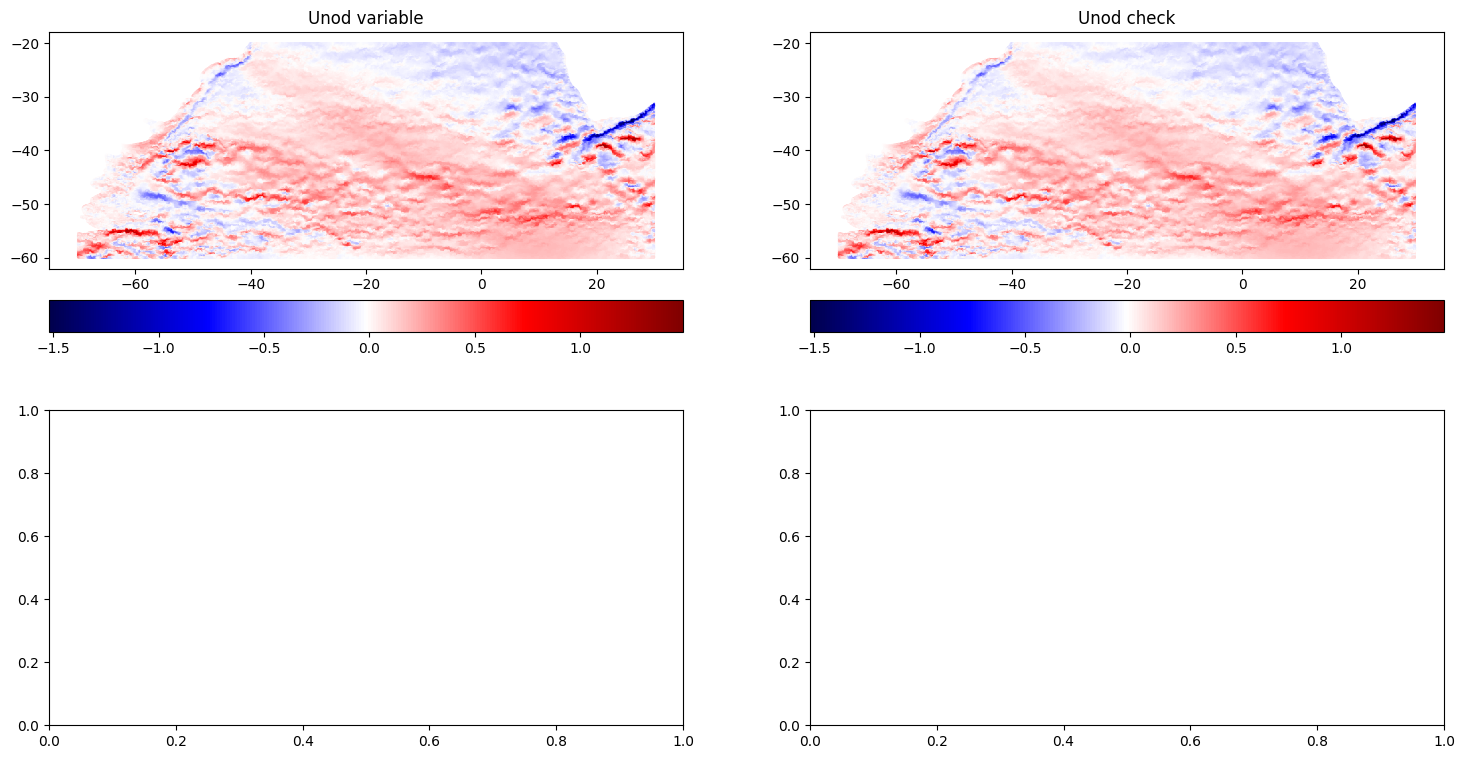

In [14]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values
unod = data_output.unod.values

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

im = axes[0][0].scatter(model_lon_roi, model_lat_roi, c=unod, s=0.1, cmap=cm.seismic)
axes[0][0].set_title("Unod variable")
cb = plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[0][0])

im2 = axes[0][1].scatter(model_lon_roi, model_lat_roi, c=data_unod.sel(time=time).unod, s=0.1, cmap=cm.seismic)
axes[0][1].set_title("Unod check")
cb = plt.colorbar(im2, orientation='horizontal', pad=0.1, ax=axes[0][1])
'''
im3 = axes[1][0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=0.1, cmap=cm.seismic, vmin=-1, vmax=1)
axes[1][0].set_title(f"The remaining nodes with SSH data after the interpolation to unstructured mesh")
plt.colorbar(im3, orientation='horizontal', pad=0.1, ax=axes[1][0])

im4 = axes[1][1].scatter(model_lon_roi, model_lat_roi, c=uns_seg_mask, s=0.1, cmap=cm.viridis, vmin=0, vmax=2)
axes[1][1].set_title(f"The remaining nodes with seg_mask data after the interpolation to unstructured mesh")
plt.colorbar(im4, orientation='horizontal', pad=0.1, ax=axes[1][1])
'''